# PyMKS Introduction

In this notebook, we are demonstrating simple case studies for calculating 2-point spatial correlations on an experimental microstructure as well as synthetic microstructures. First, we will demonstrate how to calculate spatial correlations for a single 2 phase experimental image. Then, we will demonstrate the most efficient way to calculate 2-point spatial correlations on multiple microstructures without using any for-loops. We will only use common python packages like Numpy, Scikit-learn, and Matplotlib for this introductory notebook. For parallel computation PyMKS uses Dask, but we will not be using Dask in this Notebook. Please see the [Effective Stiffness of a Composite Material example](./stress.ipynb) or [Effective Stiffness of Fiber Composite](./fiber.ipynb) notebooks that both implement parallel workflows using Scikit-learn pipelines.

Importing the necessary packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

In [2]:
from sklearn.decomposition import PCA
#PYTEST_VALIDATE_IGNORE_OUTPUT

# %matplotlib inline
%load_ext autoreload
%autoreload 2

## Reading the Experimental Data


This example is a segmented optical image with the grain interior and grain boundaries representing the two phases. See [[1]](#References) for a more complete example of machine learning using this data.

The following loads and visualizes the experimental microstructure.

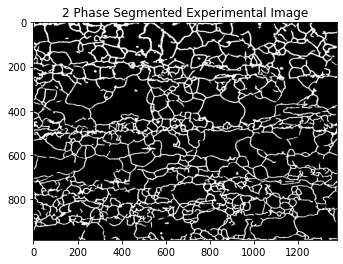

In [3]:
im = Image.open('image.tiff')
plt.figure()
plt.imshow(im,cmap='gray')
plt.title("2 Phase Segmented Experimental Image")
plt.show()

## Calculating the 2-point Stats

PyMKS can handle both Numpy and Dask arrays. For simplicity, we will only use Numpy arrays in this notebook. Note that PyMKS requires certain data shapes for proper 2-point spatial correlation calculations. For a two-dimensional microstructure, PyMKS requires a 4-dimensional array. The first dimension is the sample axis, the second dimension is the x-axis, the third dimension is the y-axis, and the fourth dimension is the phase axis. In the phase axis, the specific phase gets '1's and the rest of the image gets '0's. This is equivalent to one-hot encoding in image analysis. For this example, we have a 2-phase segmented microstructure (986 x 1376 pixels) so we need to perform some array manipulations to obtain a 1 x 986 x 1376 x 2 array. 

Convert the image to a Numpy array and add the sample axis by using the `np.expand_dims` function. Multiple images can be stacked along the sample axis.

In [4]:
imarray = np.expand_dims(np.array(im), axis=0)

In [5]:
imarray.shape

(1, 986, 1376)

The next step is to add the phase axis. Since this is a binary microstructure, we could stack the inverted version of the image with the original image. However, we are going to demonstrate the `PrimitiveTransformer` that performs the same operation and this transformer can be used for more complex cases (higher number phases and continuous values for phase information).

In [6]:
data = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(imarray)

In [7]:
data.shape

(1, 986, 1376, 2)

`PrimitiveTransformer` created the (1 x 986 x 1376 x 2) array where the last axis has the phase information. For this 2-phase 2D microstructure example, we have two 2D arrays where the first phase (grain interior) get `1's` at `[0,:,:,0]`, and the second phase (grain boundary) gets the `1's` at `[0,:,:,1]` 

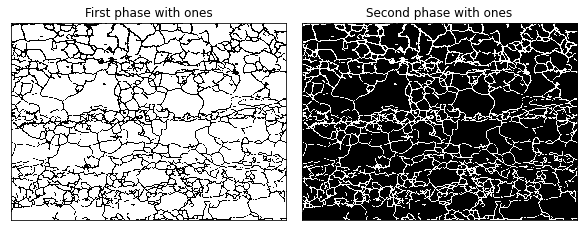

In [8]:
plot_microstructures(
    data[0, :, :, 0],
    data[0, :, :, 1],
    titles=['First phase with ones', 'Second phase with ones'],
    cmap='gray',
    colorbar=False
)

The above cell uses the `plot_microstructures` function that takes any number of 2D arrays and plots them side by side. `colorbar` can be switched on or off and the colormap, `cmap` can be changed to different settings. See the [Matplotlib documentation](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for more details.

After obtaining the data matrix with the desired shape, calculating two-point correlations are straightforward. We call the `TwoPointCorrelation` class and perform the `.transform` method. The `TwoPointCorrelation` class takes 3 parameters. The first parameter, `periodic_boundary`, is a boolean and defines the type of boundary condition. The second parameter, `cutoff`, is an integer that defines the maximum correlation vector length. The third parameter, `correlations`, is a list that defines the auto-correlations and cross-correlations of interest (e.g. `(0,0)` means auto-correlation of the first phase,`(0,1)` means cross-correlation between the first phase and the second phase).

In [9]:
auto_correlation = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=25,
    correlations=[(0,0)]
).transform(data)

In [10]:
auto_correlation.shape

(1, 51, 51, 1)

View the grain interior auto-correlation. The following image shows that the grain interior has roughly 80% volume fraction and is equiaxial (does not favor any particular direction).

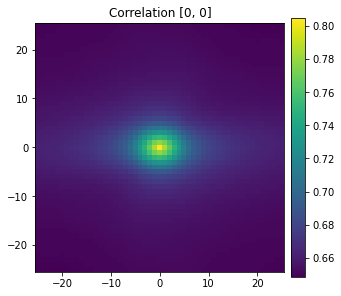

In [11]:
plot_microstructures(
    auto_correlation[0, :, :, 0],
    titles=['Correlation [0, 0]'],
    showticks=True
)

## Multiple Synthetic Microstructures

In the previous section, we demonstrated a 2-point spatial correlation calculation for a single experimental image. Now we will demonstrate calculating 2-point correlations for multiple microstructure images without using any for loops. In the following, the data array has axes representing the sample axis, the x axis, the y axis and the phase axis. 

Here we generate 40 different 2-phased synthetic microstructures each with a `100x100` shape using the function `generate_multiphase`. [Effective Siffness of a Composite Material example](./stress.ipynb) notebook has detailed explanation for the `generate_multiphase` function. 

The `generate_multiphase` function takes a domain `shape`, a `volume_fraction` for each phase,and a `grain_size` argument. The `grain_size` is a rough estimate for the desired microstructure feature size.

The following code generates four different types of microstructures each with 10 samples with spatial dimensions of 100 x 100. Each of the four samples will have a different microstructure feature size.



In [12]:
grain_sizes = [(30, 5), (10, 40), (15, 15), (5, 30)]
seeds = [10, 99, 4, 36]

data_synth = np.concatenate([
    generate_multiphase(shape=(10, 100, 100), grain_size=grain_size,
        volume_fraction=(0.5, 0.5),
        percent_variance=0.2,
        seed=seed
    )
    for grain_size, seed in zip(grain_sizes, seeds)
])


In [13]:
data_synth.shape


(40, 100, 100)

Visualize some synthetic microstructures.

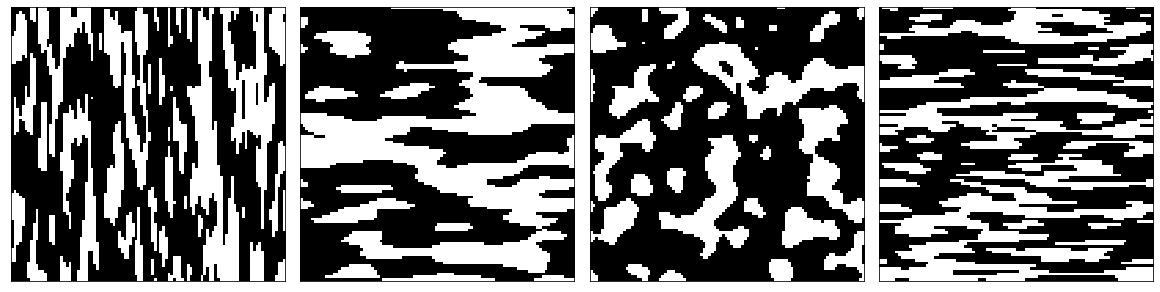

In [14]:
plot_microstructures(*data_synth[::10], cmap='gray', colorbar=False)

The `data_synth` array currently has 3 axes (sample, x-direction, y-direction). We use the `PrimitiveTransformer` to create an additional axis. As described above, this axis represent the one-hot encoded (or discretized) representation of the data.

In [15]:
data_disc = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(data_synth)

In [16]:
data_disc.shape

(40, 100, 100, 2)

We use the `TwoPointCorrelation` class to calculate 2-point spatial correlations (`[(0,0),(0,1)]`) for all 40 microstructures.

In [17]:
data_corr = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=10,
    correlations=[(0, 0), (0, 1)]
).transform(data_disc)

In [18]:
data_corr.shape

(40, 21, 21, 2)

The last axis of the `data_corr` array contains the requested auto-correlations and cross-correlations (i.e. `[0, :, :, 1]` is the `(0, 1)` cross-correlation for the first microstructure). 

The following images are the correlations for the first microstructure (white phase auto-correlation and cross correlation between white and black phases). The center point of the image has the value of the volume fraction (50%) and shows that the grains are mostly oriented in a vertical direction.

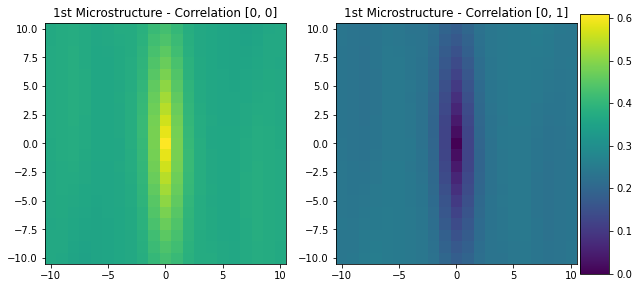

In [19]:
plot_microstructures(
    data_corr[0, :, :, 0],
    data_corr[0, :, :, 1],
    titles=['1st Microstructure - Correlation [0, 0]', '1st Microstructure - Correlation [0, 1]'],
    showticks=True
)

## Principle Component Analysis

Previously, we computed the 2-point correlations for multiple synthetic microstructures. Here, we do a principle component (PC) analysis on the correlation data to reduce the its dimensions and generate a clearer view of the data. The PC view will ideally show four clear groupings of the data based on the pattern for each microstucture category.

The PC data is first transformed from a `(40, 21, 21, 2)` shaped array into a `(40, 882)` shaped array. The Scikit-Learn `PCA` class requires a `(n_sample, n_feature)` shaped array. The `PCA` will reduce the size of the data to a `(40, 3)` shaped array, which is often enough data to capture the differences between each category of microstructure for subsequent machine learning.

In [20]:
pc_scores = PCA(
    svd_solver='full',
    n_components=3,
    random_state=10
).fit_transform(data_corr.reshape(40,-1))

 Visualize the PC scores. 

In [21]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
%matplotlib notebook

<IPython.core.display.Javascript object>


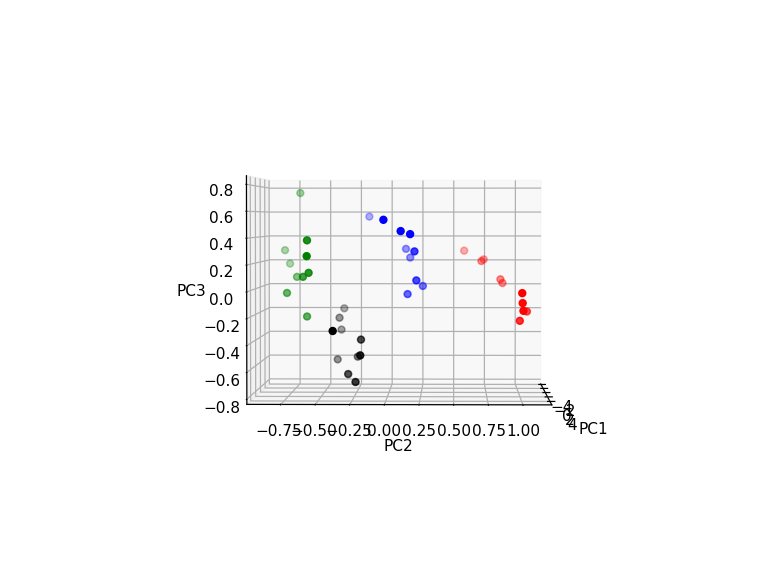

In [22]:
#PYTEST_VALIDATE_IGNORE_OUTPUT
pc1, pc2, pc3, pc4 = np.split(pc_scores, 4)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pc1[:,0], pc1[:,1], pc1[:,2], c='r', marker='o')
ax.scatter(pc2[:,0], pc2[:,1], pc2[:,2], c='g', marker='o')
ax.scatter(pc3[:,0], pc3[:,1], pc3[:,2], c='b', marker='o')
ax.scatter(pc4[:,0], pc4[:,1], pc4[:,2], c='k', marker='o')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## References

[1]  Yucel, B., Yucel, S., Ray, A. et al. Mining the Correlations Between Optical Micrographs and Mechanical Properties of Cold-Rolled HSLA Steels Using Machine Learning Approaches. Integr Mater Manuf Innov 9, 240–256 (2020). https://doi.org/10.1007/s40192-020-00183-3